## RNN model fitting

This notebook contains the fitting of the Recurrent Neural Network with LSTM cells to all series in the data set at the same time.

In [18]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from RNN.model_selection import RNNHyperTune
from RNN.data_processing import window_dataset
from DataSimulation.utils import plot_fit

In [2]:
data = pd.read_csv('data.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,11.0,4.0,43.0,31.0,15.0,3.0,56.0,7.0,322.0
1,35.0,7.0,4.0,14.0,26.0,13.0,0.0,51.0,4.0,232.0
2,10.0,4.0,5.0,9.0,43.0,44.0,4.0,39.0,3.0,416.0
3,33.0,7.0,4.0,23.0,13.0,33.0,0.0,38.0,11.0,912.0
4,4.0,4.0,4.0,17.0,16.0,21.0,2.0,52.0,14.0,3409.0


In [3]:
test_size = 12
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(188, 10)
(12, 10)


In [21]:
parameters = {
    'lstm_units':[8,16,32],
    'learning_rate':[0.1, 0.01, 0.001, 0.0001],
    'batch_size':[8,16,32],
}
rnn_hypertune = RNNHyperTune(10, 12, parameters)

In [22]:
rnn_model, scaler = rnn_hypertune.fit(
    data=train_data,
    checkpoint_path=os.path.join(os.getcwd(), 'checkpoint'),
    epochs=500
)

In [23]:
rnn_model.summary()

Model: "sequential_339"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_509 (LSTM)             (None, 32)                5504      
                                                                 
 dense_339 (Dense)           (None, 120)               3960      
                                                                 
 reshape_171 (Reshape)       (None, 12, 10)            0         
                                                                 
Total params: 9,464
Trainable params: 9,464
Non-trainable params: 0
_________________________________________________________________


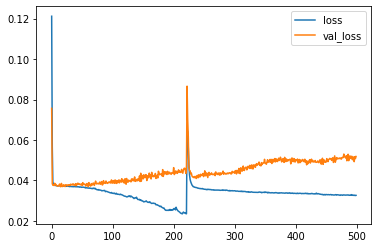

In [24]:
df = pd.DataFrame(rnn_hypertune.history.history)
df.plot(y=['loss', 'val_loss'])
plt.show()

In [25]:
scaled_data = scaler.transform(data)

In [26]:
eval_ds = window_dataset(
    data=scaled_data,
    sequence_lenght=12,
    output_lenght=12,
    batch_size=scaled_data.shape[0],
    shift=1,
    shuffle=False    
)

In [27]:
fit_values = rnn_model.predict(eval_ds)
fit_0 = fit_values[:,0,:]

1/1 [==============================] - 0s 404ms/step


In [28]:
orig_scale = scaler.inverse_transform(fit_0)

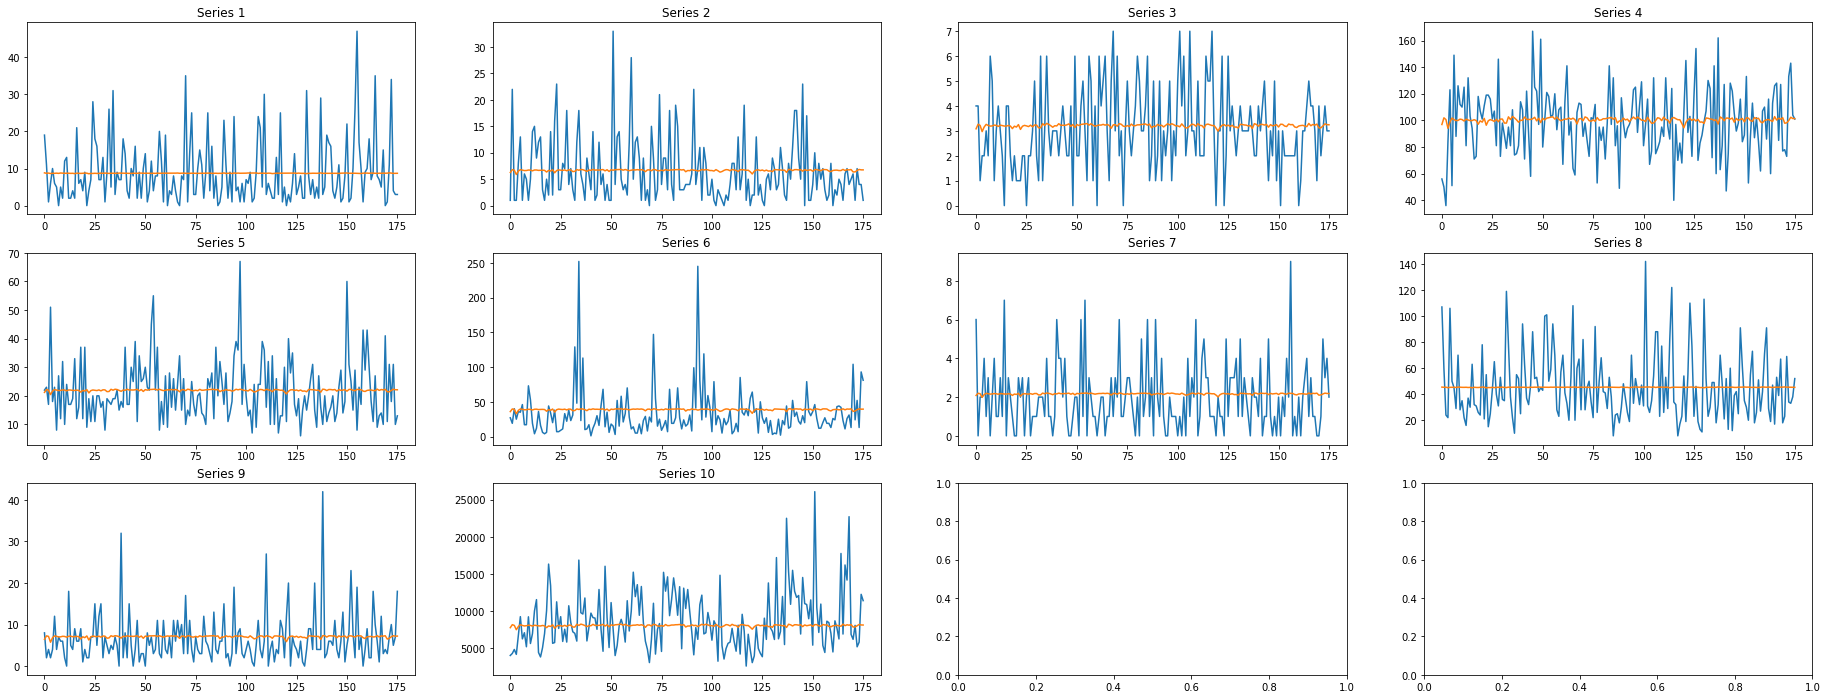

In [29]:
plot_fit(train_data[12:], orig_scale[:-1])

In [30]:
rnn_model.save("rnn.h5")

In [31]:
with open("rnn_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)